In [1]:
from amazon_scraper import AmazonScraper
import pandas as pd
import numpy as np
import csv
import re
import json
import urllib3
from bs4 import BeautifulSoup
import time
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [2]:
!python --version

Python 3.6.1 :: Anaconda 4.4.0 (64-bit)


In [3]:
with open('/home/adam/EPFL_courses/PAAPICredentials.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter='\t', quotechar='|')
    for ind, row in enumerate(spamreader):
        if ind == 1:
            Access_Key, Secret_Key = row[0].split(',')

amzn = AmazonScraper(Access_Key, Secret_Key, "bobkot-20", Region='US', MaxQPS=0.9)#, Timeout=5.0)

In [4]:
books_df = pd.read_csv("number_of_reviews_per_book.csv")
#books_df.head(15)

In [5]:
books_df['Book_id'].values[11000]

'0984588205'

In [ ]:
p = amzn.lookup(ItemId='0984588205')
p.product.author

In [7]:
http = urllib3.PoolManager(headers={'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/42.0.2311.90 Safari/537.36'})
start_iter, end_iter = 20000, 22000
iter_num = len(books_df['Book_id'].values[start_iter:end_iter])

for ind, asin in enumerate(books_df['Book_id'].values[start_iter:end_iter]):
    print(asin)
    try:
        p = amzn.lookup(ItemId=asin)
        try:
            author = p.product.author
        except:
            author = ""
        try:
            title = p.product.title
        except:
            title = ""
        try:
            brand = p.product.brand
        except:
            brand = ""
        try:
            release_date = p.product.release_date.isoformat()
        except:
            try:
                release_date = p.product.publication_date.isoformat()
            except:
                release_date = ""
        try:
            publisher = p.product.publisher
        except:
            publisher = ""
        try:
            categories = [cat_list for cat_list in [[cat.string for cat in cat_list.find_all("a")] 
                                                  for cat_list in p.soup.find_all("span", "zg_hrsr_ladder")]]
        except:
            r = http.request('GET', 'http://www.amazon.com/dp/' + asin)
            bs = BeautifulSoup(r.data, "lxml")
            try:
                categories = [cat_list for cat_list in [[cat.string for cat in cat_list.find_all("a")] 
                                                      for cat_list in bs.find_all("span", "zg_hrsr_ladder")]]

            except:
                categories = [] 
                            
        try:
            keywords = list(set(map(str.strip, map(str.lower, re.split('; |,|\*|/|;|-', p.soup.find(attrs={"name":"keywords"})['content'].replace(".", ""))))))
        except:
            try:
                keywords = list(set(map(str.strip, map(str.lower, re.split('; |,|\*|/|;|-', 
                                                    bs.find(attrs={"name":"keywords"})['content'].replace(".", ""))))))
            except:
                keywords = []    


        tmp = {'asin': asin,
               'author': author,
               'title': title,
               'brand': brand,
               'release_date': release_date,
               'publisher': publisher,
               'categories': categories,
               'keywords': keywords,
              }

        with open('product_categories.json', 'a') as fp:
            json.dump(tmp, fp)
            fp.write("\n")

    except:
        print("ASIN NOT FOUND")
    print("Processed {0}/{1} books".format(ind+1, iter_num))

B00K4IKBWK
Processed 1/2000 books
0374157065
Processed 2/2000 books
0425219763
Processed 3/2000 books
B00HZ3RTM2
Processed 4/2000 books
0486420701
Processed 5/2000 books
006087290X
Processed 6/2000 books
0425198480
Processed 7/2000 books
1595551069
Processed 8/2000 books
0553589911
Processed 9/2000 books
0345495152
Processed 10/2000 books
B005FC0MX8
Processed 11/2000 books
0373881355
Processed 12/2000 books
0312648049
Processed 13/2000 books
146101123X
Processed 14/2000 books
B00CS7EAHM
Processed 15/2000 books
0974320625
Processed 16/2000 books
1401931324
Processed 17/2000 books
0987243012
Processed 18/2000 books
1410455106
Processed 19/2000 books
1939217032
Processed 20/2000 books
0743235444
Processed 21/2000 books
0451232496
Processed 22/2000 books
0989004511
Processed 23/2000 books
1400316448
Processed 24/2000 books
1608198111
Processed 25/2000 books
B00C9L5L52
Processed 26/2000 books
0800722221
Processed 27/2000 books
1477502378
Processed 28/2000 books
B00A5XIAEA
Processed 29/2000 

Processed 231/2000 books
B00JTFVWAE
Processed 232/2000 books
1595551050
Processed 233/2000 books
014062029X
Processed 234/2000 books
0425212602
Processed 235/2000 books
0756407494
Processed 236/2000 books
0988264285
Processed 237/2000 books
0486460363
Processed 238/2000 books
0778325938
Processed 239/2000 books
0743525876
Processed 240/2000 books
0925279773
Processed 241/2000 books
1477489940
Processed 242/2000 books
1492373990
Processed 243/2000 books
0062211196
Processed 244/2000 books
0615488617
Processed 245/2000 books
1481089935
Processed 246/2000 books
0142437301
Processed 247/2000 books
B004CRTE36
Processed 248/2000 books
0062064622
Processed 249/2000 books
0061000019
Processed 250/2000 books
0778313298
Processed 251/2000 books
0982708319
Processed 252/2000 books
0553806742
Processed 253/2000 books
B005TA81BG
Processed 254/2000 books
0980037727
Processed 255/2000 books
1490423397
Processed 256/2000 books
0765368684
Processed 257/2000 books
1615190643
Processed 258/2000 books
146

Processed 457/2000 books
0812885066
Processed 458/2000 books
0451236637
Processed 459/2000 books
0802170609
Processed 460/2000 books
0060778660
Processed 461/2000 books
0671319671
Processed 462/2000 books
0615798616
Processed 463/2000 books
0470523980
Processed 464/2000 books
0316014982
Processed 465/2000 books
0425244407
Processed 466/2000 books
0310333555
Processed 467/2000 books
076532170X
Processed 468/2000 books
0061229776
Processed 469/2000 books
1484881966
Processed 470/2000 books
0545040639
Processed 471/2000 books
0863276482
Processed 472/2000 books
0310709628
Processed 473/2000 books
0060598751
Processed 474/2000 books
B0026REA92
ASIN NOT FOUND
Processed 475/2000 books
1401687407
Processed 476/2000 books
1480021946
Processed 477/2000 books
0061956996
Processed 478/2000 books
0399145877
Processed 479/2000 books
0671536141
Processed 480/2000 books
0596522347
Processed 481/2000 books
0307275663
Processed 482/2000 books
0375412913
Processed 483/2000 books
B005BOPBRC
Processed 484

Processed 683/2000 books
0316054682
Processed 684/2000 books
0505524228
Processed 685/2000 books
0615613845
Processed 686/2000 books
0718024249
Processed 687/2000 books
0425194612
Processed 688/2000 books
0804138591
Processed 689/2000 books
B003TXS7WS
Processed 690/2000 books
1416995587
Processed 691/2000 books
0061438561
Processed 692/2000 books
0786165375
Processed 693/2000 books
1612184898
Processed 694/2000 books
B009Z7903M
Processed 695/2000 books
B00AOOSRRU
ASIN NOT FOUND
Processed 696/2000 books
1615817158
Processed 697/2000 books
0345413873
Processed 698/2000 books
0802472966
Processed 699/2000 books
0393082075
Processed 700/2000 books
1442422246
Processed 701/2000 books
1402284284
Processed 702/2000 books
0764209264
Processed 703/2000 books
B00JKMLD8M
Processed 704/2000 books
0061965766
Processed 705/2000 books
0988656647
Processed 706/2000 books
082176778X
Processed 707/2000 books
0061661236
Processed 708/2000 books
B00BXKY6VA
ASIN NOT FOUND
Processed 709/2000 books
014218143

Processed 908/2000 books
0061802549
Processed 909/2000 books
1416913181
Processed 910/2000 books
034542865X
Processed 911/2000 books
0061245585
Processed 912/2000 books
0743582330
Processed 913/2000 books
B00CEHVUKQ
Processed 914/2000 books
0983829306
Processed 915/2000 books
0345311809
Processed 916/2000 books
149423730X
Processed 917/2000 books
B00H9GMPYM
Processed 918/2000 books
0802144136
Processed 919/2000 books
0758266987
Processed 920/2000 books
1601543271
Processed 921/2000 books
0399146504
Processed 922/2000 books
0553383256
Processed 923/2000 books
1416556311
Processed 924/2000 books
0061231452
Processed 925/2000 books
1451650736
Processed 926/2000 books
B00ILK05HE
Processed 927/2000 books
B00CC68FLG
Processed 928/2000 books
1482090392
Processed 929/2000 books
1453867996
Processed 930/2000 books
0451229908
Processed 931/2000 books
0061723754
Processed 932/2000 books
1419951076
Processed 933/2000 books
0451191722
Processed 934/2000 books
0764208454
Processed 935/2000 books
981

Processed 1128/2000 books
B007SC0LWK
Processed 1129/2000 books
031021792X
Processed 1130/2000 books
1484803779
Processed 1131/2000 books
9769556602
Processed 1132/2000 books
0804173524
Processed 1133/2000 books
0061451460
Processed 1134/2000 books
039914868X
Processed 1135/2000 books
145584215X
Processed 1136/2000 books
0136105688
Processed 1137/2000 books
1402236522
Processed 1138/2000 books
0345523997
Processed 1139/2000 books
1493740385
Processed 1140/2000 books
1629100048
Processed 1141/2000 books
0143115138
Processed 1142/2000 books
1595554769
Processed 1143/2000 books
039915177X
Processed 1144/2000 books
0061924687
Processed 1145/2000 books
1612187110
Processed 1146/2000 books
B00C0G25AA
Processed 1147/2000 books
162830149X
Processed 1148/2000 books
1416580557
Processed 1149/2000 books
1481054317
Processed 1150/2000 books
B00DRERCRA
ASIN NOT FOUND
Processed 1151/2000 books
0834003465
Processed 1152/2000 books
B009RDMZ86
Processed 1153/2000 books
038532720X
Processed 1154/2000 boo

Processed 1347/2000 books
0451228448
Processed 1348/2000 books
B00KXKDSCE
Processed 1349/2000 books
0763627917
Processed 1350/2000 books
030758786X
Processed 1351/2000 books
B00DLFP48Y
Processed 1352/2000 books
1613727348
Processed 1353/2000 books
0192831992
Processed 1354/2000 books
067103412X
Processed 1355/2000 books
B005Z7L4EO
Processed 1356/2000 books
B00C9KNYUM
Processed 1357/2000 books
148499986X
Processed 1358/2000 books
0849948304
Processed 1359/2000 books
1257060457
Processed 1360/2000 books
0375501770
Processed 1361/2000 books
0553380990
Processed 1362/2000 books
0152051708
Processed 1363/2000 books
0312564538
Processed 1364/2000 books
146792475X
Processed 1365/2000 books
0547150938
Processed 1366/2000 books
1612186955
Processed 1367/2000 books
1611090342
Processed 1368/2000 books
1492155489
Processed 1369/2000 books
0312646976
Processed 1370/2000 books
1889140163
ASIN NOT FOUND
Processed 1371/2000 books
1420109863
Processed 1372/2000 books
0340564067
Processed 1373/2000 boo

Processed 1566/2000 books
B00FHQI2KM
Processed 1567/2000 books
B00I4ZIZ9Q
Processed 1568/2000 books
0984924019
Processed 1569/2000 books
1453787542
Processed 1570/2000 books
1616951966
Processed 1571/2000 books
149375100X
Processed 1572/2000 books
0441014569
Processed 1573/2000 books
1442160470
Processed 1574/2000 books
0486432238
Processed 1575/2000 books
0142427225
Processed 1576/2000 books
0553383485
Processed 1577/2000 books
1414387083
Processed 1578/2000 books
B00CC3QZ8E
Processed 1579/2000 books
0380781506
Processed 1580/2000 books
061577072X
Processed 1581/2000 books
0805092676
Processed 1582/2000 books
0936184388
Processed 1583/2000 books
1595552197
Processed 1584/2000 books
0060083816
Processed 1585/2000 books
1414379366
Processed 1586/2000 books
1416520384
Processed 1587/2000 books
0425247872
Processed 1588/2000 books
0880796863
Processed 1589/2000 books
1400034183
Processed 1590/2000 books
0312992335
Processed 1591/2000 books
0374226474
Processed 1592/2000 books
B00F942XHA
P

Processed 1787/2000 books
0385350775
Processed 1788/2000 books
0451147952
Processed 1789/2000 books
0553297988
Processed 1790/2000 books
0399157204
Processed 1791/2000 books
0984332588
Processed 1792/2000 books
0316222461
Processed 1793/2000 books
B00CF225RW
Processed 1794/2000 books
B00DTT5KGI
Processed 1795/2000 books
0394709306
Processed 1796/2000 books
0399158316
Processed 1797/2000 books
0374157618
Processed 1798/2000 books
141656795X
Processed 1799/2000 books
1451678711
Processed 1800/2000 books
1466408715
Processed 1801/2000 books
B00A6IF69Q
ASIN NOT FOUND
Processed 1802/2000 books
B00ES2P6UK
Processed 1803/2000 books
0765341972
Processed 1804/2000 books
0140131558
Processed 1805/2000 books
B00II9EBH8
Processed 1806/2000 books
B005J0I2UQ
Processed 1807/2000 books
0596806396
Processed 1808/2000 books
1611790700
Processed 1809/2000 books
1937252264
Processed 1810/2000 books
1460990757
Processed 1811/2000 books
1481025392
Processed 1812/2000 books
0385349319
Processed 1813/2000 boo

In [ ]:
http = urllib3.PoolManager(headers={'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/42.0.2311.90 Safari/537.36'})

In [19]:
r = http.request('GET', 'http://www.amazon.com/dp/0989450201')


<!DOCTYPE html>
<html class="a-no-js" data-19ax5a9jf="dingo"><!-- sp:feature:head-start -->
<head><script>var aPageStart = (new Date()).getTime();</script><meta charset="utf-8"/>
<script type="text/javascript">var ue_t0=ue_t0||+new Date();</script><!-- sp:feature:cs-optimization -->
<meta content="on" http-equiv="x-dns-prefetch-control"/><link href="//images-na.ssl-images-amazon.com" rel="dns-prefetch"/><link href="//m.media-amazon.com" rel="dns-prefetch"/><link href="//completion.amazon.com" rel="dns-prefetch"/><script type="text/javascript">

var ue_csm = window,
    ue_hob = +new Date();
(function(d){var e=d.ue=d.ue||{},f=Date.now||function(){return+new Date};e.d=function(b){return f()-(b?0:d.ue_t0)};e.stub=function(b,a){if(!b[a]){var c=[];b[a]=function(){c.push([c.slice.call(arguments),e.d(),d.ue_id])};b[a].replay=function(b){for(var a;a=c.shift();)b(a[0],a[1],a[2])};b[a].isStub=1}};e.exec=function(b,a){return function(){if(1==window.ueinit)try{return b.apply(this,arguments)}catch(
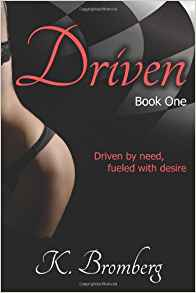

In [20]:
bs = BeautifulSoup(r.data, "lxml")
bs

In [ ]:
r = http.request('GET', 'http://www.amazon.com/dp/0989450201')
bs = BeautifulSoup(r.data, "lxml")
[cat_list for cat_list in [[cat.string for cat in cat_list.find_all("a")] 
                                                  for cat_list in bs.find_all("span", "zg_hrsr_ladder")]]

list(set(map(str.strip, map(str.lower, re.split('; |,|\*|/|;|-', bs.find(attrs={"name":"keywords"})['content'].replace(".", ""))))))

In [6]:
http = urllib3.PoolManager(headers={'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/42.0.2311.90 Safari/537.36'})
timeout = 3
with open('product_categories_2.json', 'r') as file:
    for line in file:
        tmp = eval(line)
        if tmp['categories'] == [] or tmp['keywords'] == []:
            print(tmp['asin'])
            flag = 1
            r = http.request('GET', 'http://www.amazon.com/dp/' + tmp['asin'])
            bs = BeautifulSoup(r.data, "lxml")
            while flag == 1:
                try:
                    tmp['categories'] = [cat_list for cat_list in [[cat.string for cat in cat_list.find_all("a")] 
                                                      for cat_list in bs.find_all("span", "zg_hrsr_ladder")]]

                    tmp['keywords'] = list(set(map(str.strip, map(str.lower, re.split('; |,|\*|/|;|-', 
                                                    bs.find(attrs={"name":"keywords"})['content'].replace(".", ""))))))
                    flag = 0
                    timeout = 3
                except:
                    timeout = timeout + 3
                    print("Error, can get connection, increasing timeout = {}".format(timeout))
                    time.sleep(timeout + np.random.random())
                    http = urllib3.PoolManager(headers={'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:57.0) Gecko/20100101 Firefox/57.0',
                                                        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
                                                        'Accept-Language': 'en-US,en;q=0.5', 'Accept-Encoding': 'gzip, deflate, br'})
                    flag = 1
            
            time.sleep(1 + np.random.random())
        with open('product_categories_enhanced.json', 'a') as fp:
            json.dump(tmp, fp)
            fp.write("\n")

1250026385
0061990558
0007148976
1599951967
0142181293
0373210361
0143143832
1936608367
0765304740
0142422053
0143113100
1622660005
0060874163
0316024481
0316007021
B00J47H8H8
1482008238
030795062X
0842361715
1493621890
0399158375
061582434X
1416964053
B00BT1T1ZY
0143125427
0140434240
0143123580
0143144723
0307394956
0061792268
0399159738
1451645163
0136879721
0930289528
1419956760
0143125435
0312377630
1479366935
0373794061
1933512865
0988105411
0307719219
0312387962
1595581030
097367363X
031605755X
1480170623
0061711640
1416542949
0312427085
0140293248
0993702325
0446616419
0671003364
0061962740
0451214994
0385529953
1477809716
B0076790LA
0393061728
0739322974
0805092994
1416594884
0991431308
1492170348
097935210X
1470052555
1481839020
0062072099
1590582365
0061493341
1442402326
1250010691
0062196243
0345476972
0553380966
0988273683
0986602876
0385509480
0441017770
B00HS5DYDA
0345532740
149371340X
0764211684
1491046880
0385342047
B00957XZFG
0743288408
0143119915
0983429766
0758278454

KeyboardInterrupt: 